# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация
### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

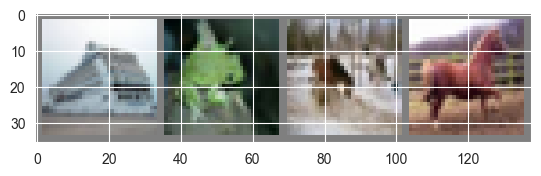

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
class BasicBlockNet(nn.Module):
    def __init__(self, num_classes=10):
        super(BasicBlockNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.shortcut = nn.Sequential()
        
        if 1 != 1 or 3 != 32:
            self.shortcut = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32)
            )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc = nn.Linear(32 * 4 * 4, num_classes)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
import torch
import numpy as np

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            
            loss = torch.nn.functional.cross_entropy(output, target)
            loss_log.append(loss.item())
            
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            acc = correct / len(target)
            acc_log.append(acc)
    
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        acc = correct / len(target)
        acc_log.append(acc)
    
    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch + 1}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 1
 train loss: 1.5002279876572995, train acc: 0.46846027030556286
 val loss: 1.284302795186956, val acc: 0.5451241134751774

Epoch 2
 train loss: 1.1789886410972972, train acc: 0.5873269783233219
 val loss: 1.0671192856545144, val acc: 0.6303191489361702

Epoch 3
 train loss: 1.0496896795206576, train acc: 0.6363443457821885
 val loss: 1.0036632454141658, val acc: 0.6477836879432625

Epoch 4
 train loss: 0.9988344189671755, train acc: 0.652618177069731
 val loss: 0.9925101526240085, val acc: 0.6590868794326242

Epoch 5
 train loss: 0.954085125129881, train acc: 0.6721565682945939
 val loss: 0.9589607398560707, val acc: 0.6636081560283689

Epoch 6
 train loss: 0.9292885741760352, train acc: 0.6776002219900757
 val loss: 0.9930884891367974, val acc: 0.6545212765957447

Epoch 7
 train loss: 0.904917250385668, train acc: 0.6863002742230347
 val loss: 0.9828764550229336, val acc: 0.6674423758865248

Epoch 8
 train loss: 0.887760261621946, train acc: 0.691564377121964
 val loss: 0.9132

Посчитайте точность на тестовой выборке:

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.6786425159235668


Точность выше 67%.

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

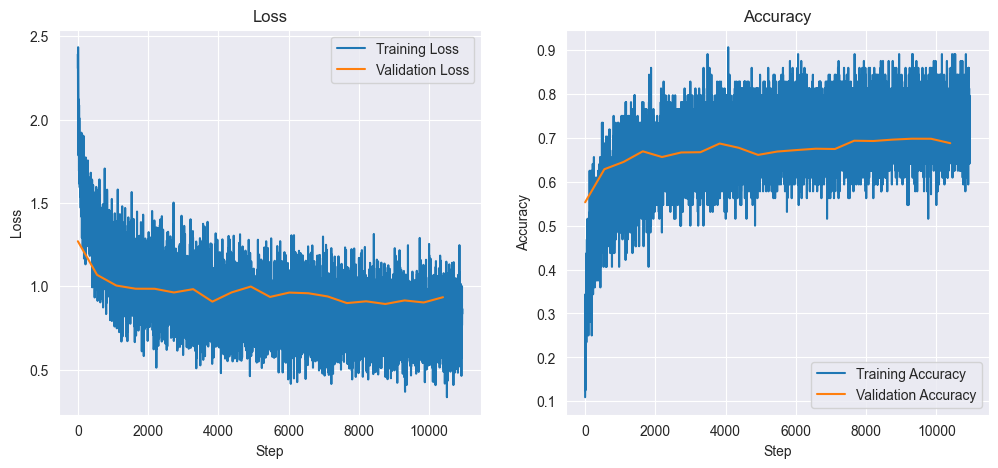

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_log, label='Training Loss')
plt.plot([i * len(train_loader) for i in range(len(val_loss_log))], val_loss_log, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_log, label='Training Accuracy')
plt.plot([i * len(train_loader) for i in range(len(val_acc_log))], val_acc_log, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [47]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 1
 train loss: 1.4985135425379332, train acc: 0.4694641224862888
 val loss: 1.2977377003811776, val acc: 0.5406693262411347

Epoch 2
 train loss: 1.2120766004435106, train acc: 0.5761907482371377
 val loss: 1.106567271212314, val acc: 0.6192819148936171

Epoch 3
 train loss: 1.0714832105192014, train acc: 0.6286644685296422
 val loss: 1.1377810531474175, val acc: 0.6092863475177306

Epoch 4
 train loss: 1.0067318339016582, train acc: 0.6500310133194045
 val loss: 1.0616768507247276, val acc: 0.6307624113475178

Epoch 5
 train loss: 0.9613313843824746, train acc: 0.6682921454687908
 val loss: 1.0100405114762327, val acc: 0.6484485815602837

Epoch 6
 train loss: 0.9300625499685242, train acc: 0.6791549686602246
 val loss: 1.0124821599493636, val acc: 0.658311170212766

Epoch 7
 train loss: 0.9033379415271487, train acc: 0.686904217811439
 val loss: 0.9234008109315913, val acc: 0.6822695035460992

Epoch 8
 train loss: 0.8882734506396096, train acc: 0.6911563071297989
 val loss: 0.92

Посчитайте точность на тестовой выборке:

In [48]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.7172571656050956


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [49]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log_const_lr, tr_acc_log_const_lr, val_loss_log_const_lr, val_acc_log_const_lr = train(net, optimizer, 20, train_loader, val_loader)

Epoch 1
 train loss: 1.7713355691167074, train acc: 0.3771831744580831
 val loss: 1.5652633631483037, val acc: 0.45467641843971635

Epoch 2
 train loss: 1.4987766925769925, train acc: 0.47247975972838857
 val loss: 1.4189274158883602, val acc: 0.5007978723404255

Epoch 3
 train loss: 1.3948753817207853, train acc: 0.5091611713241055
 val loss: 1.3551484701481271, val acc: 0.5200576241134752

Epoch 4
 train loss: 1.3363283046638725, train acc: 0.5291647623400365
 val loss: 1.312851434565605, val acc: 0.5360150709219859

Epoch 5
 train loss: 1.2940368464921466, train acc: 0.5461241512144163
 val loss: 1.260802058463401, val acc: 0.5570257092198583

Epoch 6
 train loss: 1.255454088368843, train acc: 0.5586396578741186
 val loss: 1.2349219197922565, val acc: 0.5660682624113476

Epoch 7
 train loss: 1.2243056395372045, train acc: 0.5692658004700967
 val loss: 1.1995776384434802, val acc: 0.5794769503546099

Epoch 8
 train loss: 1.1895783545766059, train acc: 0.5829034996082528
 val loss: 1.

In [50]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.6666998407643312


Качество на тестовой выборке с lr=0.001 оказалось худшим в сравнении с результатами обучения с кусочной постоянной функцией (72%) и результатами без lr_scheduler (68%).

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**ExponentialLR**

\begin{equation}
Learning \ rate(epoch) = Initial \ learning \ rate * (1 - \frac{Decay \ rate}{100})^{epoch}
\end{equation}

Экспоненциальное изменение lr: скорость обучения будет резко снижаться в течение первых нескольких эпох и замедляться в дальнейшем, большинство эпох будут протекать с меньшими значениями.

In [11]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 1
 train loss: 1.4864172642366107, train acc: 0.47220227213371646
 val loss: 1.3084059043133514, val acc: 0.5395390070921986

Epoch 2
 train loss: 1.1362445905831875, train acc: 0.6046169038913555
 val loss: 1.1093240631387589, val acc: 0.6152482269503545

Epoch 3
 train loss: 1.0755919826096112, train acc: 0.6268118307652129
 val loss: 1.0898547535246992, val acc: 0.6189051418439715

Epoch 4
 train loss: 1.0677745130859737, train acc: 0.6294112366153043
 val loss: 1.087646622099775, val acc: 0.6195700354609929

Epoch 5
 train loss: 1.0666834631393336, train acc: 0.6310190323844346
 val loss: 1.0874055187752907, val acc: 0.6204343971631204

Epoch 6
 train loss: 1.0670691840827355, train acc: 0.629729531209193
 val loss: 1.0874038351343034, val acc: 0.6204343971631204

Epoch 7
 train loss: 1.0681258308168302, train acc: 0.6310516779838078
 val loss: 1.0878106233921456, val acc: 0.6204343971631204

Epoch 8
 train loss: 1.067045692987808, train acc: 0.6289337947244712
 val loss: 1.0

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.6187300955414012


**CosineAnnealingLR**

\begin{equation}
\eta _ {t} = \eta _ {\min } + \frac {1}{2} ( \eta  _ {\max}  - \eta _ {\min } ) \times (1+ \cos ( \frac {T_ {cur}}{T_ {\max }} \pi )),
\end{equation}
\begin{align*} \text{где } \eta_{\min} \text{ и } \eta_{\max} & \text{ диапазоны для скорости обучения, при этом } n_{\max} \text{ устанавливается на начальное значение lr;} \\ T_{\text{cur}} & \text{ - количество эпох, пройденных с момента последнего перезапуска и } T_{\text{max}} \text{ - максимальное количество эпох.}
\end{align*}


Изменение lr по косинусной кривой: начинает с очень большой скорости обучения, а затем агрессивно уменьшает ее до значения, близкого к 0, прежде чем снова увеличить скорость обучения.

In [62]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 1
 train loss: 1.5329996259164549, train acc: 0.4543124836772003
 val loss: 1.2804459825475165, val acc: 0.5427969858156029

Epoch 2
 train loss: 1.2062112053743883, train acc: 0.576794691825542
 val loss: 1.0957921543019884, val acc: 0.6170877659574469

Epoch 3
 train loss: 1.0749729258268799, train acc: 0.6229392465395666
 val loss: 1.0923854498153036, val acc: 0.6248448581560284

Epoch 4
 train loss: 1.0071402194295112, train acc: 0.6519734264821102
 val loss: 1.020692929562102, val acc: 0.6436170212765957

Epoch 5
 train loss: 0.9675009651637383, train acc: 0.6645379015408722
 val loss: 0.9747547862377572, val acc: 0.6629654255319148

Epoch 6
 train loss: 0.9429787810367466, train acc: 0.6733889396709324
 val loss: 0.9380862380595918, val acc: 0.6742686170212766

Epoch 7
 train loss: 0.9159932322868264, train acc: 0.6826766126926089
 val loss: 1.0064469555591016, val acc: 0.6520833333333332

Epoch 8
 train loss: 0.8987812413485002, train acc: 0.6882549294855054
 val loss: 0.9

In [63]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.7067078025477707


**StepLR**

![Image](https://i.ibb.co/9rnZdWs/lr-shed.png)

Каждые step_size эпох значение learning rate уменьшается, то есть уменьшение значения lr на заданный фактор gamma через каждые step_size эпох.

In [65]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 1
 train loss: 1.5131325795837904, train acc: 0.46127415774353614
 val loss: 1.302402955166837, val acc: 0.533377659574468

Epoch 2
 train loss: 1.1784458886116906, train acc: 0.5859558631496473
 val loss: 1.107191117266391, val acc: 0.6173980496453901

Epoch 3
 train loss: 1.0478273071144355, train acc: 0.6370625489683991
 val loss: 1.1076532280191462, val acc: 0.6211657801418439

Epoch 4
 train loss: 0.9884047069104978, train acc: 0.6555562810133194
 val loss: 0.983914149568436, val acc: 0.660261524822695

Epoch 5
 train loss: 0.958353960317929, train acc: 0.6668108513972316
 val loss: 0.9828557478620651, val acc: 0.6618351063829787

Epoch 6
 train loss: 0.9314342431002168, train acc: 0.676767759206059
 val loss: 0.9206866069042936, val acc: 0.6818927304964539

Epoch 7
 train loss: 0.9045279612270962, train acc: 0.6874795965003917
 val loss: 0.9392478859170954, val acc: 0.6718306737588652

Epoch 8
 train loss: 0.8819810381428197, train acc: 0.6973140833115695
 val loss: 0.92421

In [66]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.6841162420382165


Наихудшее качество оказалось с ExponentialLR - 61.2%. Лучшее качество у CosineAnnealingLR - 70.7%. Побить качество с кусочно постоянной функцией (71.7%) не удалось.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

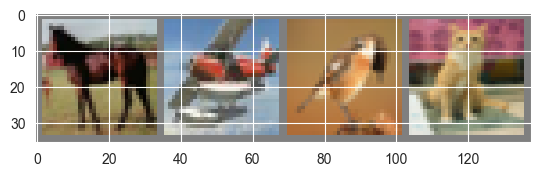

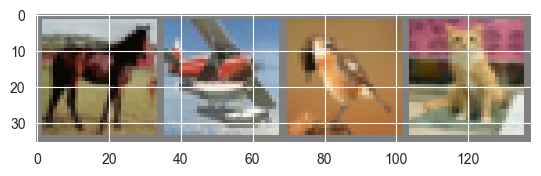

In [67]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [68]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
 train loss: 1.4920895167199089, train acc: 0.4722104335335596
 val loss: 1.2482956650409294, val acc: 0.5602393617021276

Epoch 2
 train loss: 1.189909408471702, train acc: 0.5840052885870985
 val loss: 1.1543054415824565, val acc: 0.5933510638297872

Epoch 3
 train loss: 1.0762668508062414, train acc: 0.6271219639592582
 val loss: 1.1080753765207656, val acc: 0.6074911347517731

Epoch 4
 train loss: 1.0239604042478627, train acc: 0.644501664925568
 val loss: 0.9923221050424779, val acc: 0.6572695035460993

Epoch 5
 train loss: 0.9806375331373057, train acc: 0.6605918647166362
 val loss: 1.0097375994033002, val acc: 0.6456117021276596

Epoch 6
 train loss: 0.9535440799305165, train acc: 0.6703651410289893
 val loss: 0.9797231641221553, val acc: 0.6686391843971631

Epoch 7
 train loss: 0.9225405083060046, train acc: 0.6796691368503527
 val loss: 0.9549308036236053, val acc: 0.6708111702127659

Epoch 8
 

Посчитайте точность на тестовой выборке:

In [69]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.7210390127388535


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**RandomRotation**

Поворачивает изображение на случайный угол в пределах указанного диапазона градусов.

In [70]:
transform_rotation = transforms.Compose(
    [transforms.RandomRotation(30),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform_rotation)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
 train loss: 1.6152985348779934, train acc: 0.417916721075999
 val loss: 1.446382720419701, val acc: 0.48399822695035466

Epoch 2
 train loss: 1.3805605278808413, train acc: 0.509014266126926
 val loss: 1.2910865210472269, val acc: 0.5384751773049645

Epoch 3
 train loss: 1.2749870257142257, train acc: 0.5452223165317315
 val loss: 1.293125546232183, val acc: 0.5401152482269503

Epoch 4
 train loss: 1.2172955897869968, train acc: 0.5711551645338209
 val loss: 1.166222355213571, val acc: 0.5851285460992907

Epoch 5
 train loss: 1.17858368539723, train acc: 0.5852743862627318
 val loss: 1.2085155674751769, val acc: 0.5737145390070922

Epoch 6
 train loss: 1.1454699165860303, train acc: 0.5971124967354401
 val loss: 1.3175325132430868, val acc: 0.5637854609929077

Epoch 7
 train loss: 1.1162446953042988, train acc: 0.6068939344476364
 val loss: 1.1364584572771763, val acc: 0.5966312056737588

Epoch 8
 trai

In [71]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.6870023885350318


**RandomVerticalFlip**

Случайно переворачивает изображение по вертикали.

In [85]:
transform_vertical_flip = transforms.Compose(
    [transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform_vertical_flip)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
 train loss: 1.6643643241913706, train acc: 0.3956687451031601
 val loss: 1.4962312089635972, val acc: 0.4567597517730496

Epoch 2
 train loss: 1.4084452567196415, train acc: 0.49865744972577697
 val loss: 1.3382000083618977, val acc: 0.5225620567375886

Epoch 3
 train loss: 1.2852383043473992, train acc: 0.5430554648733351
 val loss: 1.3022715812033796, val acc: 0.5349290780141843

Epoch 4
 train loss: 1.2335669296969007, train acc: 0.5635977082789241
 val loss: 1.1913373556542903, val acc: 0.580186170212766

Epoch 5
 train loss: 1.1866797023543056, train acc: 0.5816507247323062
 val loss: 1.1670781947196798, val acc: 0.5812278368794327

Epoch 6
 train loss: 1.1584176037603584, train acc: 0.5895183141812484
 val loss: 1.2604836981347267, val acc: 0.5736923758865248

Epoch 7
 train loss: 1.1265741066915245, train acc: 0.6050453773831288
 val loss: 1.1586782749663007, val acc: 0.5948138297872341

Epoch 8

In [86]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.6576433121019108


**ColorJitter**

Случайным образом изменяет яркость, контраст, насыщенность и оттенок изображения в пределах указанных диапазонов.

In [74]:
transform_color_jitter = transforms.Compose(
    [transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform_color_jitter)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
 train loss: 1.5785072316199378, train acc: 0.4394832201619222
 val loss: 1.3279793952373748, val acc: 0.5315381205673758

Epoch 2
 train loss: 1.248334662243043, train acc: 0.5659481914337947
 val loss: 1.1762731930042836, val acc: 0.5929299645390071

Epoch 3
 train loss: 1.133588910320777, train acc: 0.6091791264037607
 val loss: 1.1569473066228502, val acc: 0.5962765957446808

Epoch 4
 train loss: 1.0903205872671695, train acc: 0.6237676286236616
 val loss: 1.0945271925723299, val acc: 0.6226950354609928

Epoch 5
 train loss: 1.0476183703874102, train acc: 0.6393395795246801
 val loss: 1.0791943118927327, val acc: 0.6229609929078014

Epoch 6
 train loss: 1.0181630736513154, train acc: 0.6512552232958997
 val loss: 1.0903283086228879, val acc: 0.6321586879432625

Epoch 7
 train loss: 0.9839664496059174, train acc: 0.6604041525202403
 val loss: 1.0294232868133708, val acc: 0.6472739361702128

Epoch 8
 

In [75]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.7078025477707006


**RandomGrayscale**

Преобразует изображение в оттенки серого с вероятностью p.

In [76]:
transform_grayscale = transforms.Compose(
    [transforms.RandomGrayscale(p=0.1),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform_grayscale)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
 train loss: 1.5216048472106347, train acc: 0.45959290937581615
 val loss: 1.3135700930940344, val acc: 0.5384973404255319

Epoch 2
 train loss: 1.1986897289208127, train acc: 0.5818588404283103
 val loss: 1.1947514759733322, val acc: 0.5866578014184396

Epoch 3
 train loss: 1.0779325695098863, train acc: 0.6268975254635676
 val loss: 1.1056772579538061, val acc: 0.6162234042553192

Epoch 4
 train loss: 1.0288667657039718, train acc: 0.6427714481587882
 val loss: 1.0139901886595057, val acc: 0.6445478723404255

Epoch 5
 train loss: 0.9820908975993475, train acc: 0.6594329459388875
 val loss: 1.0187477842290351, val acc: 0.6434840425531915

Epoch 6
 train loss: 0.9550460614059699, train acc: 0.6711404740141029
 val loss: 1.0663927156874473, val acc: 0.6414450354609929

Epoch 7
 train loss: 0.923748940501832, train acc: 0.6808729433272395
 val loss: 0.9640476290215837, val acc: 0.6667774822695035

Epoch 8

In [77]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.7182523885350318


**4 в 1**

In [87]:
transform_combined = transforms.Compose(
    [transforms.RandomRotation(30),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
     transforms.RandomGrayscale(p=0.1),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform_combined)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
 train loss: 1.8812817411405296, train acc: 0.3196453055628101
 val loss: 1.7211373557435705, val acc: 0.3747340425531915

Epoch 2
 train loss: 1.708061797745267, train acc: 0.3852915252024027
 val loss: 1.6592889664020944, val acc: 0.39510195035461

Epoch 3
 train loss: 1.6239723246101923, train acc: 0.41471337163750327
 val loss: 1.6305741908702445, val acc: 0.3962987588652483

Epoch 4
 train loss: 1.5710667652883303, train acc: 0.43907923086967876
 val loss: 1.5341376243753637, val acc: 0.4495124113475177

Epoch 5
 train loss: 1.532437085669481, train acc: 0.45257818621049883
 val loss: 1.5130750158999828, val acc: 0.4542109929078015

Epoch 6
 train loss: 1.4915460282749406, train acc: 0.4696273504831549
 val loss: 1.6288436712102687, val acc: 0.44556737588652484

Epoch 7
 train loss: 1.4705078536457292, train acc: 0.47493634108122224
 val loss: 1.466758033569823, val acc: 0.484197695035461

Epoch 8


In [88]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.6046974522292994


Наилучшее качество на тестовой выборке получилось с GrayScale - 71.8. Наихудшее качество получилось у комбинации 4 аугментация изображения - 60.5%.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

[Wandb graphs](https://wandb.ai/ppc_hse/ppc_hse/runs/v409f9ir?nw=nwuserpashvasilenko)

In [13]:
import wandb

wandb.init(project="ppc_hse", 
           
           config={
           "learning_rate": 0.1,
           "batch_size": 64,
           "epochs": 20,
           }
)

wandb: Currently logged in as: pashvasilenko (ppc_hse). Use `wandb login --relogin` to force relogin


In [14]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        # Логирование метрик в wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": np.mean(train_loss),
            "train_accuracy": np.mean(train_acc),
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch + 1}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [15]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    for epoch in range(n_epochs):
        model.train()
        train_loss_log, train_acc_log = [], []
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            # Логирование метрик для обучающей выборки
            train_loss_log.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / len(target)
            train_acc_log.append(accuracy)
            
            wandb.log({
                'Train Loss': loss.item(),
                'Train Accuracy': accuracy
            }, step=epoch * len(train_loader) + batch_idx)
        
        # Оценка на валидационной выборке
        val_loss, val_acc = test(model, val_loader)
        
        wandb.log({
            'Validation Loss': val_loss,
            'Validation Accuracy': val_acc
        }, step=(epoch + 1) * len(train_loader))
        
        print(f"Epoch {epoch + 1}:")
        print(f" Train Loss: {torch.tensor(train_loss_log).mean().item()}, Train Accuracy: {torch.tensor(train_acc_log).mean().item()}")
        print(f" Validation Loss: {val_loss}, Validation Accuracy: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

In [16]:
train_loader, val_loader, test_loader = get_cifar10_data(batch_size=wandb.config.batch_size, transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train(net, optimizer, 20, train_loader, val_loader)

Epoch 1:
 Train Loss: 1.4785332679748535, Train Accuracy: 0.47387540340423584
 Validation Loss: 1.2624969086748488, Validation Accuracy: 0.5548537234042553

Epoch 2:
 Train Loss: 1.1632622480392456, Train Accuracy: 0.5928196310997009
 Validation Loss: 1.1044791477791807, Validation Accuracy: 0.6133200354609928

Epoch 3:
 Train Loss: 1.050211787223816, Train Accuracy: 0.6360015869140625
 Validation Loss: 1.1187049284894415, Validation Accuracy: 0.6021719858156029

Epoch 4:
 Train Loss: 1.0015828609466553, Train Accuracy: 0.6515898704528809
 Validation Loss: 1.0053984710510742, Validation Accuracy: 0.6513076241134752

Epoch 5:
 Train Loss: 0.9599088430404663, Train Accuracy: 0.667777955532074
 Validation Loss: 0.9681027447923701, Validation Accuracy: 0.6617021276595745

Epoch 6:
 Train Loss: 0.9273523688316345, Train Accuracy: 0.6761148571968079
 Validation Loss: 0.994341194883306, Validation Accuracy: 0.6587765957446808

Epoch 7:
 Train Loss: 0.9047116637229919, Train Accuracy: 0.686794

In [18]:
test_loss, test_acc = test(net, test_loader)
print(f"Точность на тесте: {test_acc}")

Точность на тесте: 0.7025278662420382


In [19]:
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})